

# Step 1. Data Preprocessing and Data Cleaning and Feature Selection




# 1.1 Daatset Loading



In [ ]:

from google.colab import drive
import pandas as pd
import numpy as np
import sys


drive.mount('/content/drive')

# Load the dataset
file_path = ('/content/drive/MyDrive/RT_IOT2022.csv')  # Ensure that the file path is correctly pointing to the dataset
dataset = pd.read_csv(file_path)

# Display the first few rows to verify the data loading (optional)
print("First few rows of the dataset:")
print(dataset.head())



Mounted at /content/drive
First few rows of the dataset:
   no  id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0   0      38667       1883   tcp    mqtt      32.011598             9   
1   1      51143       1883   tcp    mqtt      31.883584             9   
2   2      44761       1883   tcp    mqtt      32.124053             9   
3   3      60893       1883   tcp    mqtt      31.961063             9   
4   4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  ...  active.std  \
0             5                  3                  3  ...         0.0   
1             5                  3                  3  ...         0.0   
2             5                  3                  3  ...         0.0   
3             5                  3                  3  ...         0.0   
4             5                  3                  3  ...         0.0   

       idle.min      idle.max      idle.tot      idle


# 1.2 Data Cleaning



In [ ]:


# Check for missing values in the dataset
missing_values = dataset.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])  # Display only columns with missing values

# Separate numeric and non-numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns
non_numeric_cols = dataset.select_dtypes(exclude=[np.number]).columns

# Handle missing values for numeric columns
dataset[numeric_cols] = dataset[numeric_cols].fillna(dataset[numeric_cols].mean())

# For non-numeric columns, one might fill missing values with a placeholder or the mode, depending on the context
# Example: Filling with the most frequent value (mode)
dataset[non_numeric_cols] = dataset[non_numeric_cols].fillna(dataset[non_numeric_cols].mode().iloc[0])

# Verify that all missing values have been handled
print("\nMissing values after cleaning:")
print(dataset.isnull().sum().sum())  # Should be 0 if all missing values are handled







Missing values in each column:
Series([], dtype: int64)

Missing values after cleaning:
0



# 1.3 Feature Selection



In [ ]:


# Select relevant features for model training
features = [
    'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
    'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
    'fwd_init_window_size', 'bwd_init_window_size'
]

# Target variable
target = 'Attack_type'

# Separate the features (X) and the target (y)
X = dataset[features]
y = dataset[target]

# Display the shapes of X and y to verify correct selection
print("\nShape of feature set X:", X.shape)
print("Shape of target set y:", y.shape)

# Display the first few rows of the feature set and target to verify
print("\nFirst few rows of the feature set X:")
print(X.head())

print("\nFirst few rows of the target set y:")
print(y.head())






Shape of feature set X: (123117, 9)
Shape of target set y: (123117,)

First few rows of the feature set X:
   flow_duration  fwd_pkts_tot  bwd_pkts_tot  fwd_data_pkts_tot  \
0      32.011598             9             5                  3   
1      31.883584             9             5                  3   
2      32.124053             9             5                  3   
3      31.961063             9             5                  3   
4      31.902362             9             5                  3   

   bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0                  3          0.281148          0.156193   
1                  3          0.282277          0.156821   
2                  3          0.280164          0.155647   
3                  3          0.281593          0.156440   
4                  3          0.282111          0.156728   

   fwd_init_window_size  bwd_init_window_size  
0                 64240                 26847  
1                 64240         



# 1.4 EDA (Exploratory Data Analysis)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer


# Handling missing values
# Fill missing values with the mean for numerical columns and the most frequent value for categorical columns
numerical_cols = dataset.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = dataset.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

dataset[numerical_cols] = imputer_num.fit_transform(dataset[numerical_cols])
dataset[categorical_cols] = imputer_cat.fit_transform(dataset[categorical_cols])






In [ ]:



# Convert categorical variables to numerical formats
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
    label_encoders[col] = le

# Verify if there are any remaining missing values
print("\nTotal Missing Values After Imputation:")
print(dataset.isnull().sum().sum())







Total Missing Values After Imputation:
0


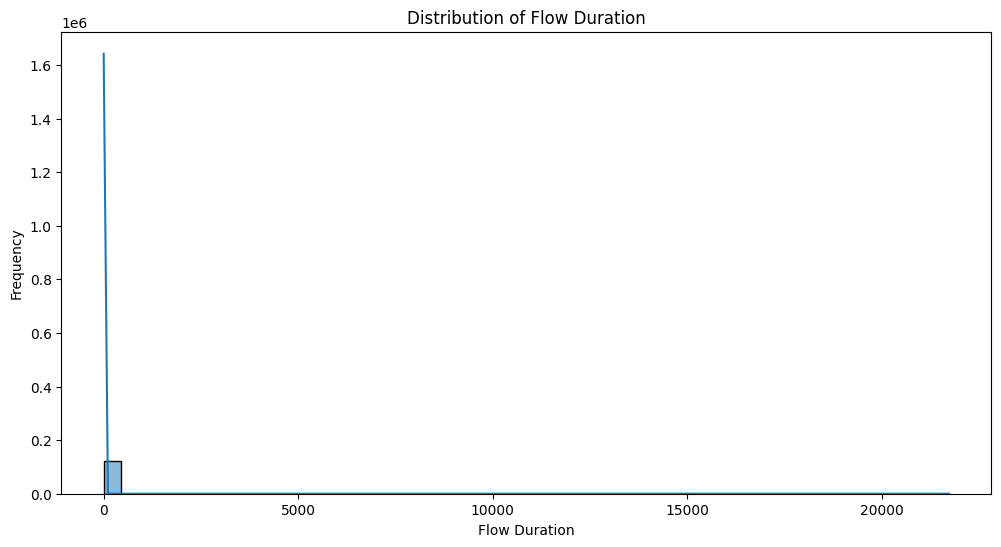

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distributions of some numerical columns
plt.figure(figsize=(12, 6))
sns.histplot(dataset['flow_duration'], bins=50, kde=True)
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.show()





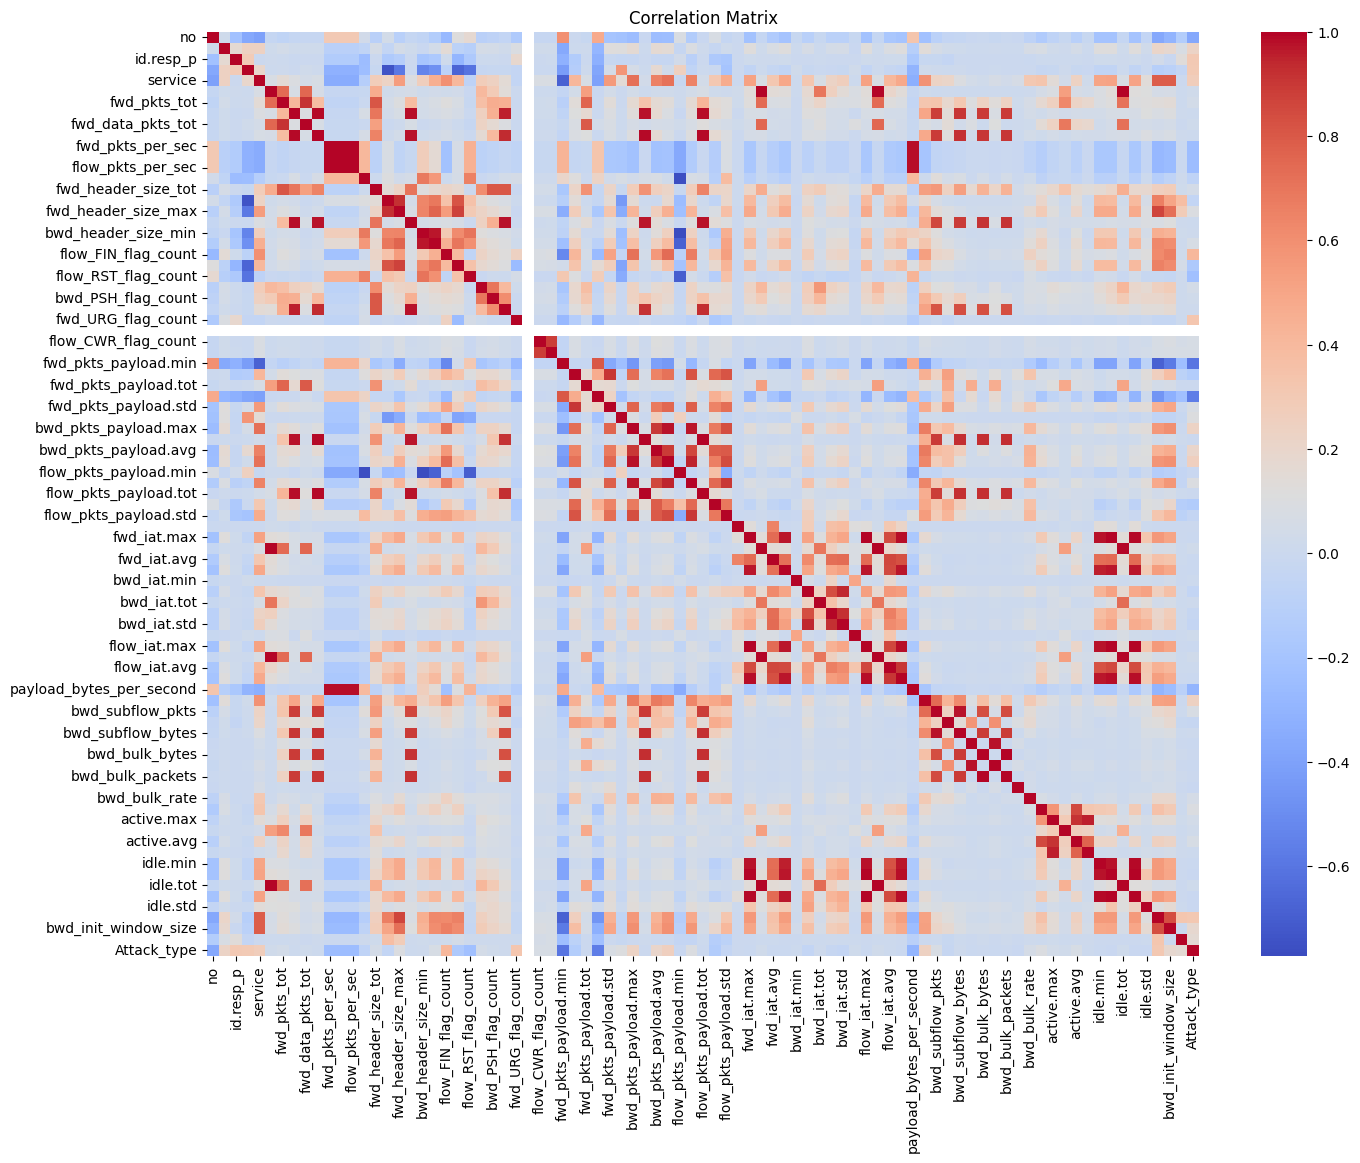

In [ ]:



# Plotting correlation matrix
plt.figure(figsize=(16, 12))
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()







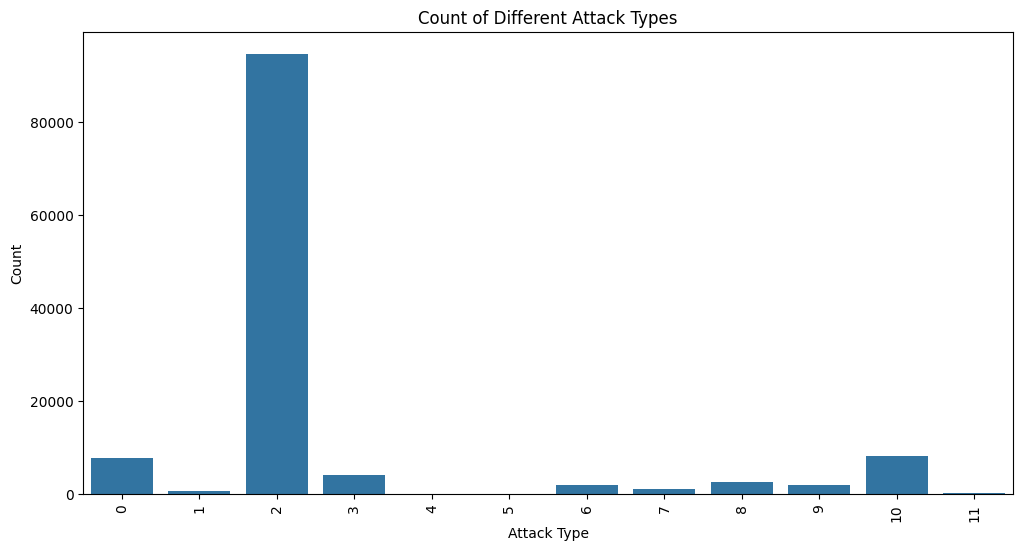

In [ ]:




# Plotting the count of different attack types
plt.figure(figsize=(12, 6))
sns.countplot(x='Attack_type', data=dataset)
plt.title('Count of Different Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()





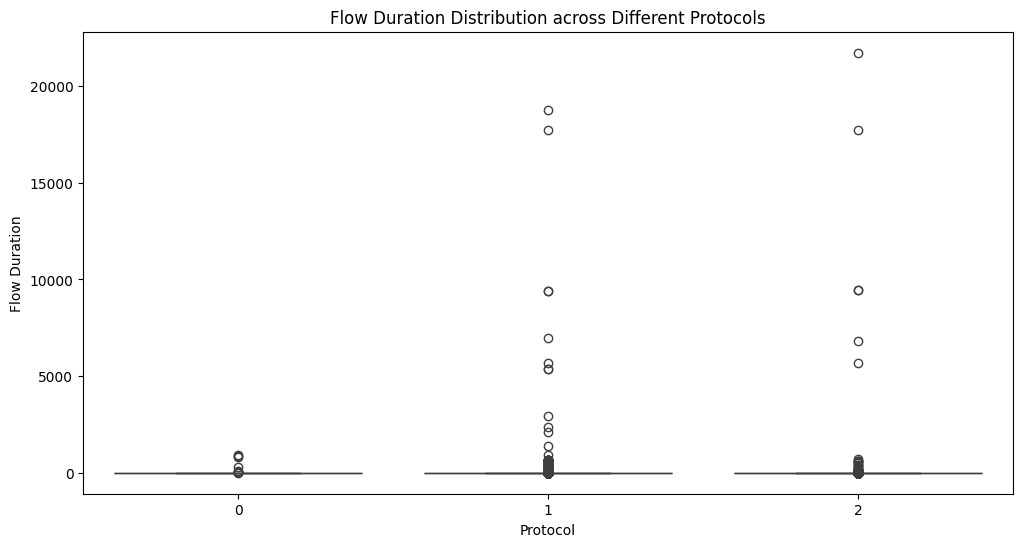

In [ ]:


# Boxplot to observe distribution of 'flow_duration' across different 'proto'
plt.figure(figsize=(12, 6))
sns.boxplot(x='proto', y='flow_duration', data=dataset)
plt.title('Flow Duration Distribution across Different Protocols')
plt.xlabel('Protocol')
plt.ylabel('Flow Duration')
plt.show()




# The data is now preprocessed and ready for model training.



# Step 2: Data Splitting and Model Training

In [ ]:

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, LSTM, Dropout, Reshape, Input




# Step 2.1: Data Splitting

In [ ]:


# Encode the target labels (since they are categorical)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)






# Step 2.2: Build and Train the BiGRU Model

In [ ]:


# Define the BiGRU model
bigru_model = Sequential()

# Input layer with reshaping to fit GRU input requirements
bigru_model.add(Input(shape=(X_train.shape[1],)))
bigru_model.add(Reshape((X_train.shape[1], 1)))

# GRU and Dense layers
bigru_model.add(Bidirectional(GRU(64)))
bigru_model.add(Dropout(0.5))
bigru_model.add(Dense(64, activation='relu'))
bigru_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
bigru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
bigru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the BiGRU model on the test set
y_pred_bigru = bigru_model.predict(X_test)
y_pred_bigru_classes = y_pred_bigru.argmax(axis=1)

print("\nBiGRU Model Accuracy:", accuracy_score(y_test, y_pred_bigru_classes))
print("\nBiGRU Model Classification Report:")
print(classification_report(y_test, y_pred_bigru_classes, target_names=label_encoder.classes_))




Epoch 1/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9048 - loss: 0.3045 - val_accuracy: 0.9498 - val_loss: 0.1202
Epoch 2/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9465 - loss: 0.1270 - val_accuracy: 0.9540 - val_loss: 0.1037
Epoch 3/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9505 - loss: 0.1128 - val_accuracy: 0.9530 - val_loss: 0.1102
Epoch 4/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9519 - loss: 0.1093 - val_accuracy: 0.9550 - val_loss: 0.1010
Epoch 5/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9528 - loss: 0.1062 - val_accuracy: 0.9554 - val_loss: 0.0990
Epoch 6/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9517 - loss: 0.1054 - val_accuracy: 0.9555 - val_loss: 0.0980
Epoch 7/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9522 - loss: 0.1035 - val_accuracy: 0.9557 - val_loss: 0.0987
Epoch 8/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9510 - loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



# Step 2.3: Build and Train the BiLSTM Model

In [ ]:


# Define the BiLSTM model
bilstm_model = Sequential()

# Correctly reshape input for LSTM
bilstm_model.add(Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)))

# Add Bidirectional LSTM layers
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dropout(0.5))

# Add Dense layers for classification
bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the BiLSTM model on the test set
y_pred_bilstm = bilstm_model.predict(X_test)
y_pred_bilstm_classes = y_pred_bilstm.argmax(axis=1)

print("\nBiLSTM Model Accuracy:", accuracy_score(y_test, y_pred_bilstm_classes))
print("\nBiLSTM Model Classification Report:")
print(classification_report(y_test, y_pred_bilstm_classes, target_names=label_encoder.classes_))




Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2463/2463 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.8954 - loss: 0.3242 - val_accuracy: 0.9476 - val_loss: 0.1290
Epoch 2/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9427 - loss: 0.1356 - val_accuracy: 0.9518 - val_loss: 0.1130
Epoch 3/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9480 - loss: 0.1217 - val_accuracy: 0.9546 - val_loss: 0.1072
Epoch 4/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9509 - loss: 0.1147 - val_accuracy: 0.9541 - val_loss: 0.1049
Epoch 5/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9526 - loss: 0.1074 - val_accuracy: 0.9533 - val_loss: 0.1035
Epoch 6/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9515 - loss: 0.1077 - val_accuracy: 0.9522 - val_loss: 0.1037
Epoch 7/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9532 - loss: 0.1053 - val_accuracy: 0.9576 - val_loss: 0.1012
Epoch 8/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9534 - loss: 0.1029 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




# Step 3: Hyperparameter Tuning and Regularization of BiLSTM Model and BiGRU Model

In [ ]:

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, LSTM, Dropout, Reshape, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras_tuner as kt



In [ ]:

# Encode the target labels (since they are categorical)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Function to build and tune BiGRU model
def build_bigru_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Reshape((X_train.shape[1], 1)))

    # Tune the number of units in GRU
    model.add(Bidirectional(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                                kernel_regularizer=l2(hp.Choice('l2_reg', values=[1e-2, 1e-3])))))

    # Tune dropout rate
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Add Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    # Tune the learning rate
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Function to build and tune BiLSTM model
def build_bilstm_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Reshape((X_train.shape[1], 1)))

    # Tune the number of units in LSTM
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                                 kernel_regularizer=l2(hp.Choice('l2_reg', values=[1e-2, 1e-3])))))

    # Tune dropout rate
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Add Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    # Tune the learning rate
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model






In [ ]:


# Initialize the tuner for BiGRU model
tuner_bigru = kt.Hyperband(build_bigru_model,
                           objective='val_accuracy',
                           max_epochs=10,
                           factor=3,
                           directory='my_dir',
                           project_name='bigru_tuning')

# Initialize the tuner for BiLSTM model
tuner_bilstm = kt.Hyperband(build_bilstm_model,
                            objective='val_accuracy',
                            max_epochs=10,
                            factor=3,
                            directory='my_dir',
                            project_name='bilstm_tuning')

# Run the hyperparameter search for BiGRU model
tuner_bigru.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best model from tuning
best_bigru_model = tuner_bigru.get_best_models(num_models=1)[0]

# Evaluate the best BiGRU model on the test set
y_pred_best_bigru = best_bigru_model.predict(X_test)
y_pred_best_bigru_classes = y_pred_best_bigru.argmax(axis=1)

print("\nBest BiGRU Model Accuracy:", accuracy_score(y_test, y_pred_best_bigru_classes))
print("\nBest BiGRU Model Classification Report:")
print(classification_report(y_test, y_pred_best_bigru_classes, target_names=label_encoder.classes_))

# Run the hyperparameter search for BiLSTM model
tuner_bilstm.search(X_train, y_train, epochs=10, validation_split=0.2)

# Get the best model from tuning
best_bilstm_model = tuner_bilstm.get_best_models(num_models=1)[0]

# Evaluate the best BiLSTM model on the test set
y_pred_best_bilstm = best_bilstm_model.predict(X_test)
y_pred_best_bilstm_classes = y_pred_best_bilstm.argmax(axis=1)

print("\nBest BiLSTM Model Accuracy:", accuracy_score(y_test, y_pred_best_bilstm_classes))
print("\nBest BiLSTM Model Classification Report:")
print(classification_report(y_test, y_pred_best_bilstm_classes, target_names=label_encoder.classes_))




Trial 30 Complete [00h 02m 18s]
val_accuracy: 0.9554799795150757

Best val_accuracy So Far: 0.9612670540809631
Total elapsed time: 00h 35m 31s


/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


770/770 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Best BiLSTM Model Accuracy: 0.9581302794022092

Best BiLSTM Model Classification Report:
                            precision    recall  f1-score   support

            ARP_poisioning       0.79      0.88      0.83      1578
            DDOS_Slowloris       0.67      0.82      0.74       100
             DOS_SYN_Hping       1.00      1.00      1.00     18897
              MQTT_Publish       0.96      1.00      0.98       871
Metasploit_Brute_Force_SSH       0.00      0.00      0.00         6
             NMAP_FIN_SCAN       0.00      0.00      0.00         3
         NMAP_OS_DETECTION       0.00      0.00      0.00       393
             NMAP_TCP_scan       0.98      1.00      0.99       220
             NMAP_UDP_SCAN       0.99      0.56      0.72       489
       NMAP_XMAS_TREE_SCAN       0.49      0.98      0.65       384
               Thing_Speak       0.89      0.91      0.90      1625
                Wipro_bulb       0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

# Build and train the Hybrid CNN-BiGRU model
hybrid_bigru_model = build_hybrid_bigru_model()
hybrid_bigru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the Hybrid CNN-BiGRU model on the test set
y_pred_hybrid_bigru = hybrid_bigru_model.predict(X_test)
y_pred_hybrid_bigru_classes = y_pred_hybrid_bigru.argmax(axis=1)

print("\nHybrid CNN-BiGRU Model Accuracy:", accuracy_score(y_test, y_pred_hybrid_bigru_classes))
print("\nHybrid CNN-BiGRU Model Classification Report:")
print(classification_report(y_test, y_pred_hybrid_bigru_classes, target_names=label_encoder.classes_))

# Build and train the Hybrid CNN-BiLSTM model
hybrid_bilstm_model = build_hybrid_bilstm_model()
hybrid_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the Hybrid CNN-BiLSTM model on the test set
y_pred_hybrid_bilstm = hybrid_bilstm_model.predict(X_test)
y_pred_hybrid_bilstm_classes = y_pred_hybrid_bilstm.argmax(axis=1)

print("\nHybrid CNN-BiLSTM Model Accuracy:", accuracy_score(y_test, y_pred_hybrid_bilstm_classes))
print("\nHybrid CNN-BiLSTM Model Classification Report:")
print(classification_report(y_test, y_pred_hybrid_bilstm_classes, target_names=label_encoder.classes_))



Epoch 1/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 288s 115ms/step - accuracy: 0.8620 - loss: 0.4607 - val_accuracy: 0.9327 - val_loss: 0.1422
Epoch 2/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 282s 115ms/step - accuracy: 0.9346 - loss: 0.1523 - val_accuracy: 0.9513 - val_loss: 0.1179
Epoch 3/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 282s 115ms/step - accuracy: 0.9455 - loss: 0.1290 - val_accuracy: 0.9519 - val_loss: 0.1177
Epoch 4/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 282s 114ms/step - accuracy: 0.9478 - loss: 0.1206 - val_accuracy: 0.9528 - val_loss: 0.1057
Epoch 5/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 281s 114ms/step - accuracy: 0.9509 - loss: 0.1156 - val_accuracy: 0.9585 - val_loss: 0.1014
Epoch 6/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 281s 114ms/step - accuracy: 0.9534 - loss: 0.1112 - val_accuracy: 0.9560 - val_loss: 0.1108
Epoch 7/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 282s 114ms/step - accuracy: 0.9526 - loss: 0.1145 - val_accuracy: 0.9579 - val_loss: 0.0980
Epoch 8/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 281s 114ms/step - ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2463/2463 ━━━━━━━━━━━━━━━━━━━━ 212s 85ms/step - accuracy: 0.8562 - loss: 0.5254 - val_accuracy: 0.9395 - val_loss: 0.1565
Epoch 2/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 210s 85ms/step - accuracy: 0.9324 - loss: 0.1715 - val_accuracy: 0.9409 - val_loss: 0.1495
Epoch 3/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 210s 85ms/step - accuracy: 0.9363 - loss: 0.1615 - val_accuracy: 0.9469 - val_loss: 0.1336
Epoch 4/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 210s 85ms/step - accuracy: 0.9385 - loss: 0.1543 - val_accuracy: 0.9414 - val_loss: 0.1505
Epoch 5/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 210s 85ms/step - accuracy: 0.9336 - loss: 0.1632 - val_accuracy: 0.9428 - val_loss: 0.1320
Epoch 6/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 210s 85ms/step - accuracy: 0.9417 - loss: 0.1408 - val_accuracy: 0.9497 - val_loss: 0.1195
Epoch 7/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 211s 86ms/step - accuracy: 0.9437 - loss: 0.1343 - val_accuracy: 0.9483 - val_loss: 0.1241
Epoch 8/10
2463/2463 ━━━━━━━━━━━━━━━━━━━━ 211s 86ms/step - accuracy: 0.9469 - lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
